#### PRIMAL-DUAL: Dynamic Match Scheduling

In [1]:
import sys
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import random

In [2]:
def draw_hypergraph(lambda_, M, r):
    """
    Given the arrivals, match types, and rewards, draws the corresponding hypergraph
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
        
    Output: None
    """
    M = M.T

    vertices = [str(j+1)+" : "+str(i)+"λ" for j, i in enumerate(lambda_)]
    
    edges = []
    for row in M.T:
        new = []
        for i in range(len(row)):
            if row[i] == 1:
                new.append(vertices[i])
        edges.append(new)


    plt.figure(figsize=(8, 4))
    # Define the hypergraph
    hypergraph = {
        'vertices': vertices,
        'edges': edges
    }

    # Create a NetworkX graph object
    graph = nx.Graph()

    # Add the vertices to the graph
    graph.add_nodes_from(hypergraph['vertices'], bipartite=0)

    # Add the hyperedges to the graph
    for i, edge in enumerate(hypergraph['edges']):
        hyperedge_id = f'r{i+1} = '+str(r[i])  # Unique identifier for each hyperedge
        graph.add_node(hyperedge_id, bipartite=1)  # Add hyperedge as a node
        graph.add_edges_from([(v, hyperedge_id) for v in edge])  # Connect vertices to the hyperedge

    # Set the bipartite layout
    pos = nx.bipartite_layout(graph, hypergraph['vertices'], align='horizontal')

    # Separate the nodes based on bipartite attribute
    vertices = [node for node in graph.nodes if graph.nodes[node]['bipartite'] == 0]
    hyperedges = [node for node in graph.nodes if graph.nodes[node]['bipartite'] == 1]


    # Draw the nodes with different shapes
    nx.draw_networkx_nodes(graph, pos, nodelist=vertices, node_color='lightblue', node_shape='o', node_size=4000)
    nx.draw_networkx_nodes(graph, pos, nodelist=hyperedges, node_color='lightblue', node_shape='s', node_size=4000)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), width=2, alpha=0.5, edge_color='gray')

    # Draw the labels
    nx.draw_networkx_labels(graph, pos, font_size=9)
    
    M = M.T

    # Display the graph
    plt.axis('off')
    plt.show()

In [3]:
def preprocessing(lambdas, M, r):
    """
    Normalizes the arrival rates
    Check if the input sizes match
    Check if self-matches exist and satisfy "Assumption 1"
    Generate self_rewards list representing the rewards of self matches
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
    
    Output: updated lambdas, M, r, self_rewards
    """
    
    # Normalize lambdas
    lambdas = np.array(lambdas)
    lambdas = (lambdas/lambdas.sum()).round(3)
    
    
    # Check if the input sizes match
    for i in M:
        if len(i) != len(lambdas):
            print("sizes of M and lambdas don't match")
            return False
        
    if len(r) != len(M):
        print("sizes of M and r don't match")
        return False
    
    
    # Check if self-matches exist, create self_rewards
    self_rewards = []
    for i in range(len(lambdas)):
        new = [0]*len(lambdas)
        new[i] = 1
        self_rewards.append(r[M.tolist().index(new)])
        
        
    # Check if self matches rewards satisfy "Assumption 1"
    count = 0 # number of combined matches
    for i in range(len(M)):
        if (M[i]).sum() == 1:
            continue
            
        count += 1
        if r[i] <= M[i] @ self_rewards:
            print("Sum of individual self-matches of match ", M[i], "is", M[i] @ self_rewards, \
                  ", while the combined reward is ", r[i])
            return False
        
    if count == 0:
        print("No non self-matches")
        return False
        
    return lambdas, M, r, self_rewards

In [4]:
def general_position_gap(lambdas, M, r):
    """
    Solves the static-planning problem to find the general position gap.
    Checks if the problem satisfies the general position condition
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
    
    Output: general position gap, int
    """
    
    m = gp.Model("SPP")
    m.setParam("Outputflag", 0)

    z = m.addMVar(len(r), lb=0, vtype=gp.GRB.CONTINUOUS, name = "z var")
    s = m.addMVar(len(lambdas), lb=0, vtype=gp.GRB.CONTINUOUS, name = "slack var")
    m.setObjective(r @ z, GRB.MAXIMIZE)
    m.addConstr(M.T @ z + s == lambdas)
    m.optimize()
    
    num = 0  # |Q+| + |M+|
    
    epsilon = float("inf")
    for i in s.X:
        if i > 0:
            num += 1
            if i < epsilon:
                epsilon = i
    for i in z.X:
        if i > 0:
            num += 1
            if i < epsilon:
                epsilon = i
                
    if num != len(lambdas):
        print("Warning: General Position Condition does not hold!")
    else:
        print("Satisfies the General Position Condition ✓")
    
    print("Obj Val: ", m.objVal)
    print(m.getConstrs())
    print("Dual: ", [o.pi for o in m.getConstrs()])
    return epsilon

In [5]:
def arrival(lambdas):
    """
    Given the arrival rates, this function randomly generates a single arrival 
    
    Inputs:
        lambdas - arrival rates, list
    
    Output: a list of 0s and 1 representing the single arrival, list
    """
    events = list(range(0, len(lambdas)))
    res = [0] * len(lambdas)
    res[random.choices(events, lambdas)[0]] = 1
    return np.array(res)

In [6]:
def U_hat(lambdas, M, r):
    """
    Solves the dual of SPP to find U^
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
        
    Outputs: U^, list
    """
    m = gp.Model("Expression 8")
    m.setParam("Outputflag", 0)
    
    U_hat = m.addMVar(len(lambdas), vtype=gp.GRB.CONTINUOUS, name = "U hat")
    m.addConstr(M @ U_hat >= r)        
    m.setObjective(lambdas @ U_hat, GRB.MINIMIZE)
    m.optimize()
    
    return np.array(U_hat.X)

In [7]:
def hindsight_solution(lambdas, M, r, A, t):
    """
    Perfoms the hindsight optimization for arrivals that happened before t.
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
        A - a matrix representing true arrivals, matrix
        t - time point, int
    
    Output: objective value, int
    """

    m = gp.Model("Hindight Solution")
    m.setParam("Outputflag", 0)

    x = m.addMVar(len(r), lb=0, vtype=gp.GRB.INTEGER, name = "x var")
    m.setObjective(r @ x, GRB.MAXIMIZE)
    m.addConstr(M.T @ x <= sum(A[:t+1]))
    m.optimize()

    return m.objVal

In [8]:
def primal_dual(lambdas, M, r, T = 500):
    """
    Perfoms the primal-dual algorithm (details in the paper).
    Calculates and plots the regret and # of waiting agents over time.
    
    Inputs:
        lambdas - arrival rates, list
        M - a matrix representing the participants of the matches (horizontal), matrix
        r - rewards, list
        T - number of decision epochs, int
    
    Output: A, X, Y, Deltas, I 
    """
    
    lambdas, M, r, self_rewards = preprocessing(lambdas, M, r)
        
    A = []    # arrival history
    Deltas = [np.zeros(len(lambdas))]
    X = [np.zeros(len(r))]      # scheduled
    Y = [np.zeros(len(r))]      # realized
    I = np.zeros(len(r))
    
    for t in range(1, T):
        # observe arrival
        arriv = arrival(lambdas)
        A.append(arriv)

        # THE SCHEDULING PROCESS:
        delta = Deltas[-1] + M.T @ X[-1] - arriv
        Deltas.append(delta)

        Vt = t**2
        U = U_hat(lambdas, M, r) + delta/Vt

        if (r - M @ U <= 0).all():
            X.append(np.zeros(len(r)))

        else:
            xt = np.zeros(len(r))
            xt[(r - M @ U ).argmax()] = 1
            X.append(xt)

        # THE REALIZATION PROCESS
        yt = np.zeros(len(r))
        W = sum(X) - sum(Y)

        for m in range(len(M)):
            if W[m] > 0:
                I[m] = min([(sum(A) - M.T @ sum(Y))[j] for j  in range(len(lambdas)) if M[m][j] == 1])
                yt[m] = yt[m] + min(W[m], max(I[m], 0))
                
                if yt[m] < 0:
                    print("yt < 0")
                    yt[m] = 0
        Y.append(yt)
    
    
    # Caclulate regret:
    regret_hist = []
    hindsight_hist = []
    reward_hist = []
    for t in range(1, T):
        hindsight_hist.append(hindsight_solution(lambdas, M, r, A, t))
        reward_hist.append(r @ sum(Y[:1+t]))
        regret_hist.append(hindsight_hist[-1] - reward_hist[-1])
        
    # Plot regret:
    plt.figure(figsize=(10.8, 6.4))
    plt.plot(range(1, T), regret_hist)
    plt.xlabel('time')
    plt.ylabel('regret')
    plt.title('regret vs time')
    plt.show()
    
    # Plot hindsight & primal-dual
    plt.figure(figsize=(10.8, 6.4))
    plt.plot(range(1, T), hindsight_hist, label = "hindsight")
    plt.plot(range(1, T), reward_hist, label = "primal-dual")
    plt.legend()
    plt.xlabel('time')
    plt.ylabel('reward')
    plt.title('hinsight & primal-dual vs time')
    plt.show()
    
    
    # Agents waiting:
    waiting = []
    for t in range(1, T):
        waiting.append(t - (M.T @ sum(Y[:t])).sum())
    
    plt.figure(figsize=(10.8, 6.4))
    plt.plot(range(1, T), waiting)
    plt.xlabel('time')
    plt.ylabel('agents waiting')
    plt.title('agents waiting vs time')

    # Displaying the plot
    plt.show()
    
    
    return A, X, Y, Deltas, I

## Experiment 1

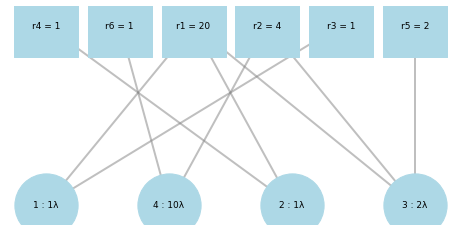

In [61]:
r = np.array([20, 4, 1, 1, 2, 1])
M = np.array([[1, 1, 1, 0], 
              [0, 0, 1, 1],
              [1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
lambdas = np.array([1, 1, 2, 10])


draw_hypergraph(lambdas, M, r)

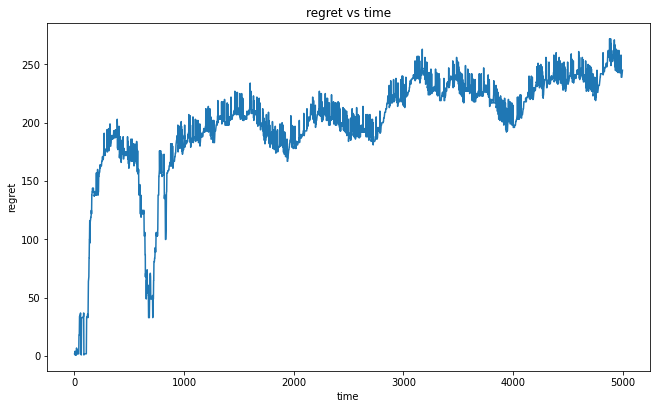

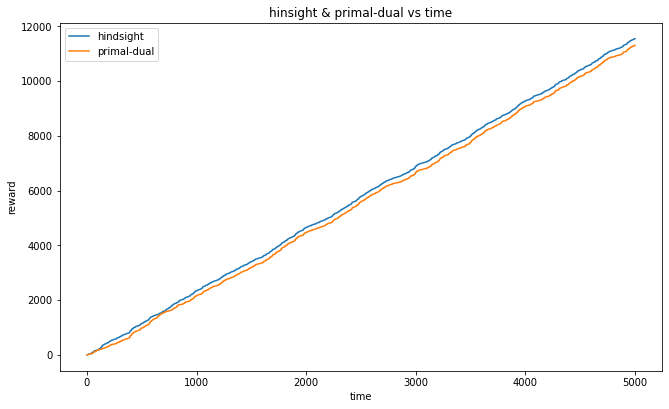

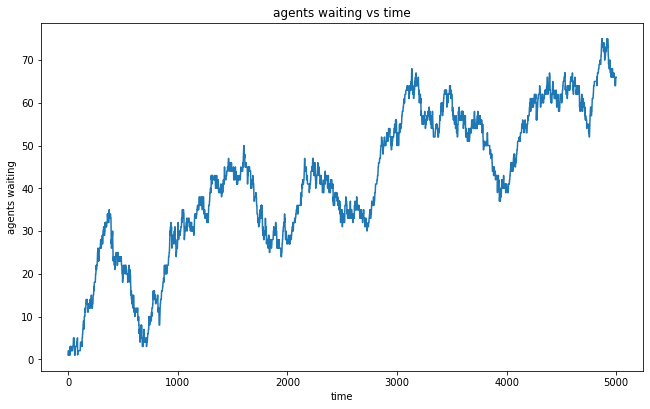

In [62]:
A, X, Y, Deltas, I = primal_dual(lambdas, M, r, T = 5000)

## Experiment 2 (multi-way, Figure 7, page 18)

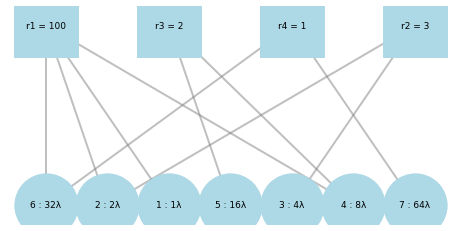

In [9]:
r = np.array([100, 3, 2, 1])
M = np.array([[1, 1, 0, 1, 0, 1, 0],
              [0, 1, 1, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 0, 0],
              [0, 0, 0, 0, 0, 1, 1]])
lambdas = np.array([1, 2, 4, 8, 16, 32, 64])


draw_hypergraph(lambdas, M, r)

# Add self-matches with 0 values
M = np.concatenate((M, np.eye(len(lambdas))), axis = 0)
r = np.concatenate((r, np.zeros(len(lambdas))))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-19


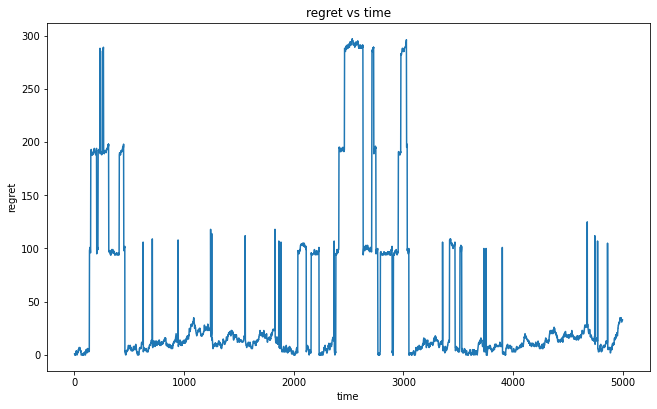

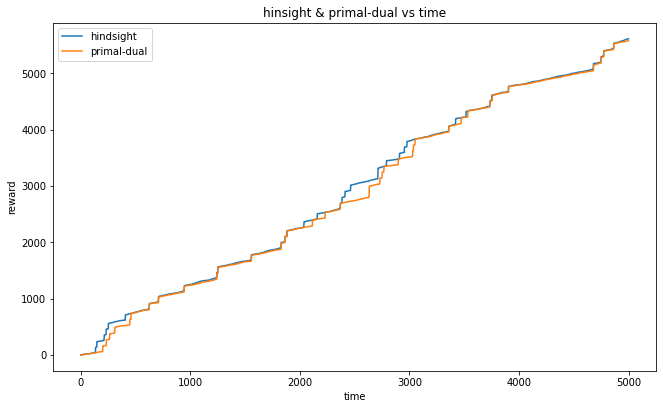

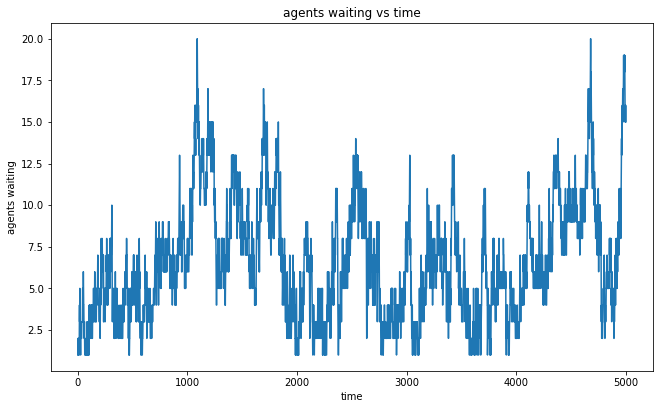

In [10]:
A, X, Y, Deltas, I = primal_dual(lambdas, M, r, T = 5000)

## Experiment 3 ([2, 100, 2])

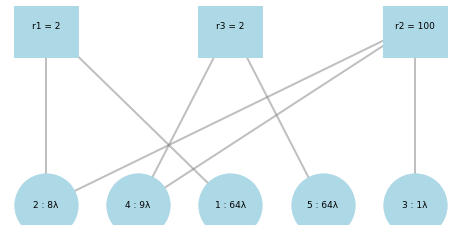

In [12]:
r = np.array([2, 100, 2])
M = np.array([[1, 1, 0, 0, 0],
              [0, 1, 1, 1, 0],
              [0, 0, 0, 1, 1]])
lambdas = np.array([64, 8, 1, 9, 64])

draw_hypergraph(lambdas, M, r)

# Add self-matches with 0 values
M = np.concatenate((M, np.eye(len(lambdas))), axis = 0)
r = np.concatenate((r, np.zeros(len(lambdas))))


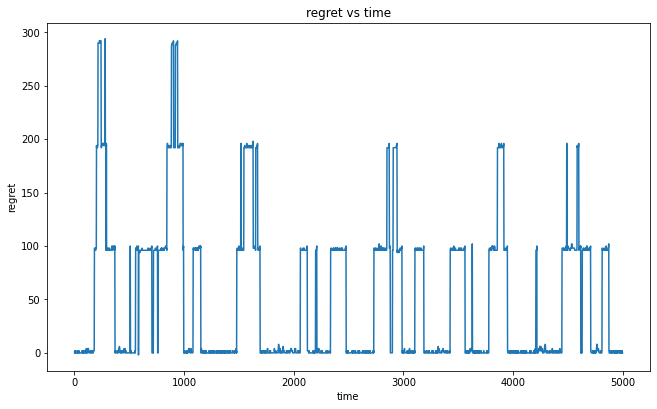

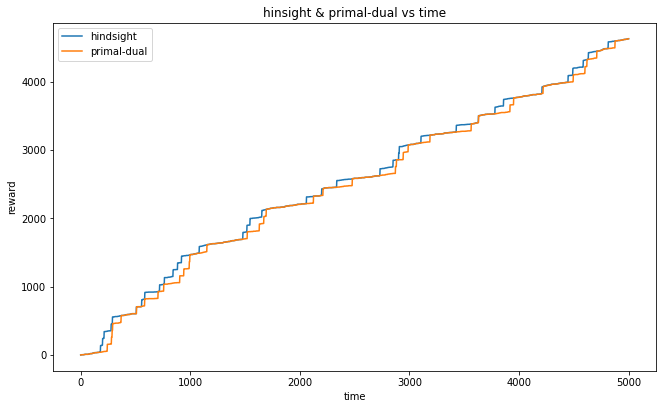

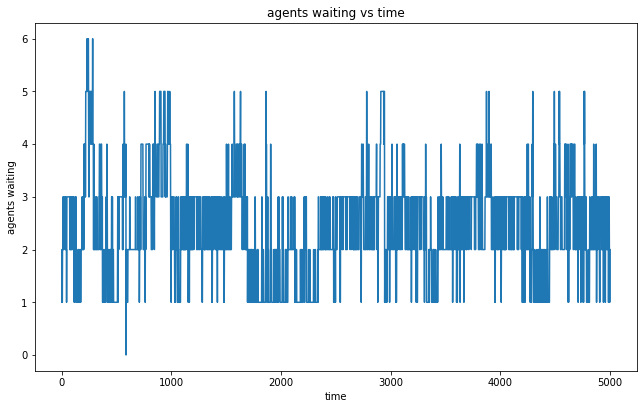

In [13]:
A, X, Y, Deltas, I = primal_dual(lambdas, M, r, T = 5000)